In [ ]:
!pip install yfinance
!pip install finta

In [ ]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
NUM_DAYS = 10000
INTERVAL = '1d'
symbol = 'AAPL'      

INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

[*********************100%***********************]  1 of 1 completed
6893


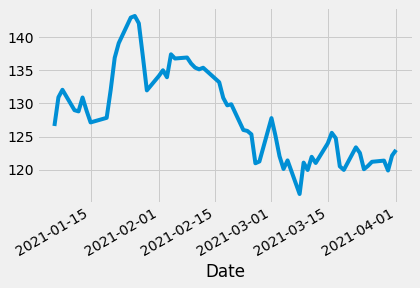

In [ ]:
start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(len(data))

tmp = data.iloc[-60:]
tmp['close'].plot()

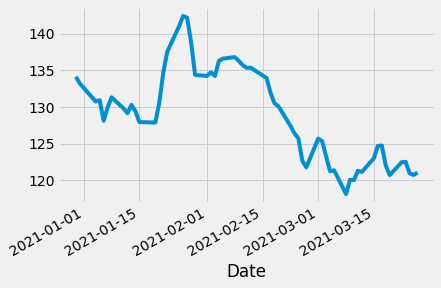

In [ ]:
def _exponential_smooth(data, alpha):

    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

In [ ]:
len(tmp1)

NameError: ignored

In [ ]:
def _get_indicator_data(data):

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    #data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    #data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    #data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    #data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    #del (data['open'])
    #del (data['high'])
    #del (data['low'])
    #del (data['volume'])
    #del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', '14 period RSI',
       'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV', '14 period ATR', 'MOM',
       '14 period MFI', 'ROC', 'OBV', '20 period CCI', '14 period EMV', 'VIm',
       'VIp', 'normVol'],
      dtype='object')


In [ ]:
live_pred_data = data.iloc[-16:-11]

In [ ]:
def _produce_prediction(data, window):

    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
#del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()
print(len(data))

6863


In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

def cross_Validation(data):
    count = 0
    total = 0
    num_train = 10
    len_train = 20
    rf_RESULTS = []
    knn_RESULTS = []
    #cat_RESULTS = []
    xg_RESULTS = []
    gb_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()
    xg = XGBClassifier()
    #cat = CatBoostClassifier()
    gb= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
    estimators=[('knn', knn), ('rf', rf) , ('xg',xg) ,('gb',gb)]
    ensemble = VotingClassifier(estimators, voting='soft')
    
    while True:
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        if len(df) < 2  0:
            break
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle = False)
        rf.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        xg.fit(X_train, y_train)
        #cat.fit(X_train, y_train)
        try:
          gb.fit(X_train, y_train)
          ensemble.fit(X_train, y_train)
          total+=1
        except:
          count+=1
          continue
        rf_prediction = rf.predict(X_test)
        knn_prediction = knn.predict(X_test)
        xg_prediction = xg.predict(X_test)
        #cat_prediction = cat.predict(X_test)
        gb_prediction = gb.predict(X_test)
        ensemble_prediction = ensemble.predict(X_test)
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        xg_accuracy = accuracy_score(y_test.values, xg_prediction)
        #cat_accuracy = accuracy_score(y_test.values, cat_prediction)
        gb_accuracy = accuracy_score(y_test.values, gb_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        xg_RESULTS.append(xg_accuracy)
        #cat_RESULTS.append(cat_accuracy)
        gb_RESULTS.append(gb_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)                
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('XG Accuracy = ' + str( sum(xg_RESULTS) / len(xg_RESULTS)))
    #print('CAT Accuracy = ' + str( sum(cat_RESULTS) / len(cat_RESULTS)))
    print('GB Accuracy = ' + str( sum(gb_RESULTS) / len(gb_RESULTS)))
    print('ENSEMBLE Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    print(count,total)
    return ensemble
    
ensemble = cross_Validation(data)


RF Accuracy = 0.7919831223628692
KNN Accuracy = 0.7185654008438818
XG Accuracy = 0.7029535864978899
GB Accuracy = 0.7721518987341773
ENSEMBLE Accuracy = 0.7767932489451478
290 395


In [ ]:
y_temp = data['pred']
features = [x for x in data.columns if x not in ['pred']]
X_temp = data[features]

In [ ]:
X_temp

,open,close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,,,
1993-12-02,0.284246,0.282930,1.034425e+08,42.885740,-0.001108,-0.000126,29.447181,-9.425402e+08,0.011349,-0.015502,46.289226,-0.628507,7.444172e+08,-80.506013,9.826907e-09,0.990793,1.033896,0.977005,0.977654,0.978343,0.983086,0.847168
1993-12-03,0.283749,0.281838,1.145086e+08,40.928164,-0.001366,-0.000381,14.915335,-9.970782e+08,0.011032,-0.017034,40.118458,-5.156032,6.299087e+08,-83.601124,5.500423e-09,0.995693,1.030004,0.975119,0.976088,0.977046,0.982878,0.948189
1993-12-06,0.282125,0.285808,1.421145e+08,49.885956,-0.001300,-0.000569,27.658149,-1.036495e+09,0.010926,-0.010313,39.810491,-4.230077,7.720232e+08,-50.382549,-1.403251e-08,1.008236,0.998418,0.989612,0.990676,0.991689,0.997294,1.141558
1993-12-07,0.284458,0.287198,9.124335e+07,52.595480,-0.001146,-0.000687,32.118133,-1.047688e+09,0.010156,-0.005060,34.486979,-3.905967,8.632665e+08,-38.232319,-4.610407e-08,1.084746,0.987768,0.994786,0.995852,0.996837,1.001771,0.768469
1993-12-08,0.285274,0.285508,5.766997e+07,49.117588,-0.001122,-0.000775,31.275813,-1.067903e+09,0.009264,-0.008300,21.479130,-3.584118,8.055965e+08,-42.017120,-8.043266e-08,1.154708,0.937909,0.989618,0.990761,0.991789,0.996584,0.532857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01,123.619998,125.674260,1.297406e+08,38.206919,-2.390508,-1.053193,28.096962,-1.064931e+12,3.578792,-9.682003,14.672632,-7.390614,2.097581e+11,-101.211094,-3.026644e-02,1.167993,0.711893,1.007621,0.965611,0.963614,0.985181,1.104606
2021-03-02,126.733502,125.313993,1.117192e+08,37.524967,-2.420482,-1.326650,26.550633,-1.064864e+12,3.727472,-8.634201,16.381752,-7.401692,2.096464e+11,-78.111568,-2.745516e-02,1.150675,0.748292,1.004639,0.964472,0.963366,0.985254,0.958976
2021-03-03,125.483224,123.198896,1.121815e+08,33.719700,-2.585107,-1.578342,13.935172,-1.064893e+12,3.838939,-8.728969,16.046380,-8.981754,2.095342e+11,-92.097616,-2.989960e-02,1.168331,0.743263,0.987921,0.950431,0.950458,0.973716,0.968928


In [ ]:
list(ensemble.predict(X_temp)).count(1.0)

1858

In [ ]:
data.corr()

,open,close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
open,1.000000,0.999920,-0.337897,0.142432,0.489054,0.527862,0.107777,-0.644178,0.906782,0.237646,0.097304,0.024543,0.697286,0.094498,0.128723,-0.151040,0.094227,0.125883,0.082853,0.066585,0.037550,0.007297,0.053613
close,0.999920,1.000000,-0.338285,0.144084,0.488928,0.527144,0.110152,-0.644370,0.906240,0.240233,0.098277,0.025484,0.697467,0.096167,0.129607,-0.151856,0.095178,0.126363,0.083726,0.067684,0.039322,0.006986,0.054147
volume,-0.337897,-0.338285,1.000000,-0.020617,-0.148478,-0.150151,-0.015026,0.063359,-0.228106,-0.094266,-0.037121,0.013877,-0.069571,-0.004757,-0.037574,-0.015091,-0.038866,0.061143,0.002129,-0.010054,-0.017244,0.415881,-0.026812
14 period RSI,0.142432,0.144084,-0.020617,1.000000,0.447327,0.386906,0.858283,-0.166942,0.016907,0.424531,0.839549,0.775730,0.179131,0.864313,0.190845,-0.878234,0.878257,0.760107,0.872130,0.881855,0.778825,0.009456,0.079774
MACD,0.489054,0.488928,-0.148478,0.447327,1.000000,0.962566,0.301145,-0.200525,0.294099,0.667763,0.370633,0.257567,0.231231,0.315671,0.533119,-0.409321,0.403843,0.336606,0.348328,0.328181,0.222001,0.007576,0.047436
SIGNAL,0.527862,0.527144,-0.150151,0.386906,0.962566,1.000000,0.209781,-0.212930,0.365649,0.462923,0.299031,0.185390,0.246533,0.227772,0.355387,-0.329147,0.317228,0.333123,0.318076,0.282249,0.153049,0.020810,0.033604
14 period STOCH %K,0.107777,0.110152,-0.015026,0.858283,0.301145,0.209781,1.000000,-0.149862,0.015129,0.431160,0.765183,0.770727,0.158837,0.902509,0.189489,-0.798466,0.805187,0.538224,0.688136,0.748349,0.797606,-0.007505,0.075629
MFV,-0.644178,-0.644370,0.063359,-0.166942,-0.200525,-0.212930,-0.149862,1.000000,-0.507556,-0.106928,-0.107493,-0.013904,-0.979437,-0.106938,-0.037454,0.198527,-0.121988,-0.103811,-0.068905,-0.057445,-0.037817,-0.005945,-0.092717
14 period ATR,0.906782,0.906240,-0.228106,0.016907,0.294099,0.365649,0.015129,-0.507556,1.000000,0.058022,-0.006189,-0.036486,0.559555,-0.001164,-0.043168,-0.035031,-0.018026,0.065188,0.005410,-0.011695,-0.023162,-0.003141,0.032949
MOM,0.237646,0.240233,-0.094266,0.424531,0.667763,0.462923,0.431160,-0.106928,0.058022,1.000000,0.376173,0.337172,0.121017,0.419307,0.719441,-0.419638,0.432380,0.224640,0.289365,0.314124,0.320997,-0.031730,0.061719
